# Before
It's my first time to creat a neural network, please correct me if there is anything wrong in the notebook

# About Fashion MNIST

Here are the categories in the Fashion-MNIST

|Label | Class |
|-|-|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|



# Ready to work

In [34]:
import os # 파이썬을 이용해 파일을 복사하거나 디렉터리를 생성하고 특정 디렉터리 내의 파일 목록을 구하고자 할 때 사용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader
# dataset : 샘플과 정답(label)을 저장
# DataLoader : Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

위의 코드는 pytorch로 사용하기 위해 필요한 라이브러리를 Import한 코드이다.

In [35]:
epochs = 10 # 훈련 반복수
batch_size = 512 # 배치 크기

device = ("cuda" if torch.cuda.is_available() else "cpu") # device 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개의 클래스

print(torch.__version__)
print(device)


2.0.1
cpu


class 와 device 및 torch의 버전을 확인하는 코드이다.

Fashion Mnist의 Class는 총 10개,
cpu를 통해 작업을 진행하였다.


# Load data

In [36]:
transform = transforms.Compose([
    transforms.Resize(227), # Compose : transforms 리스트 구성
    # 227x227 : input image(in alexnet) but fashionMNIST's input image : 28x28
    transforms.ToTensor()]) # ToTensor : PIL image or numpy.ndarray를 tensor로 바꿈

training_data = datasets.FashionMNIST(
    root="data", # data가 저장될 경로(path)
    train=True, # training dataset
    download=True, # 인터넷으로부터 데이터 다운
    transform=transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, # test dataset
    download=True,
    transform=transform
)

기존 28 X 28 Fashion Mnist 이미지 크기를,
AlexNet의 input size인 227 X 227로 Resize하여 조절하는 transform 코드이다.


## Dataset

To build our own dataset, need to create a class that inherits from the `Dataset`. Besides, function `get_item()` & `len()` must be defined at least

- `get_item()` return the specified image and its label
- `len()` return the number of dataset

In [37]:
# (class) DataLoader(dataset, batch_size, shuffle, ...)
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

Fashion Mnist의 데이터셋을 DataLoader로 감싸 사용하는 코드이다. 이를 사용하면 Batch_size 및 다양한 옵션을 사용할 수 있다.

## Transform

T-shirt/top


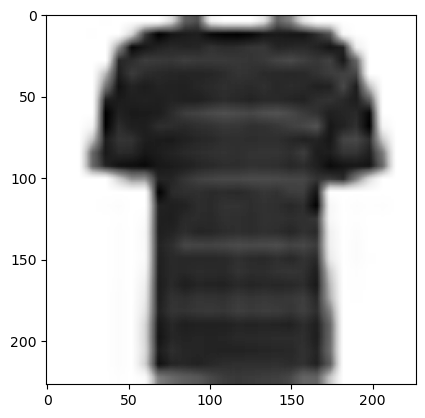

In [39]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
# get some random training images
dataiter = iter(training_loader) # iter(호출가능한객체, 반복을끝낼값)
images, labels = next(dataiter) # next() : 반복할 수 있을 때는 해당 값을 출력하고, 반복이 끝났을 때는 기본값을 출력

# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) # make_grid : 이미지의 그리드 생성

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

Fashion Mnist의 이미지중 하나를 시각화하는 코드

## Show images

In [40]:
class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
        
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0), 
            # 4D tensor : [number_of_kernels, input_channels, kernel_width, kernel_height] 
            # = 96x1x11x11
            # input size : 1x227x227
            # input size 정의 : (N, C, H, W) or (C, H, W)
            # W' = (W-F+2P)/S + 1
            # 55x55x96 feature map 생성 (55는 (227-11+1)/4)
            # 최종적으로 227 -> 55
            nn.ReLU(), # 96x55x55
            nn.MaxPool2d(kernel_size=3, stride=2) 
            # 55 -> (55-3+1)/2 = 26.5 = 27
            # 96x27x27 feature map 생성

        ) 
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), # in_channels: 96, out_channels: 256, kernel_size=5x5, stride=1, padding=2
            # kernel 수 = 48x5x5 (드롭아웃을 사용했기 때문에 96/2=48) 형태의 256개
            # 256x27x27
            nn.ReLU(),
            nn.MaxPool2d(3, 2) # 27 -> 13
            # 256x13x13
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU() # 13 유지
            # 384x13x13
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU() # 13 유지
            # 384x13x13
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2) # 13 -> 6
            # 256x6x6
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x): # input size = 3x227x227
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out) # 64x4096x1x1
        out = out.view(out.size(0), -1) # 64x4096
        
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        
        return out
        

AlexNet의 구조이다. torchvision을 통해 backbone에서 라이브러리로 제공되어 있지만, 스크레치로 작성한 코드이다.

# AlexNet

![](https://i.loli.net/2020/02/17/xd6oNRpWSK1cZy2.png)

# model


In [41]:
model = fashion_mnist_alexnet().to(device) # to()로 모델에 gpu 사용
criterion = F.nll_loss # nll_loss : negative log likelihood loss
optimizer = optim.Adam(model.parameters()) # model(신경망) 파라미터를 optimizer에 전달해줄 때 nn.Module의 parameters() 메소드를 사용

optimizer와 loss를 지정해준다.

## train funation

In [42]:
from torchsummary import summary as summary_

summary_(model, (1,227,227), batch_size)
# summary_: (model, input_size, batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

torch에서 제공해주는 summary를 이용하여, paramater size와 각 layer마다 shape를 확인할 수 있다.

## test function


In [43]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train하기 위한 작업을 함수로 작성

# Begin to Train

In [ ]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: 0.626035
Train Epoch:1 [3776/60000 (6%)]	Loss: 0.608980
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.507157
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.406372
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.614337
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.390337
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.516942
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.656299
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.316480
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.343767
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.387674
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.329419
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.237538
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.375562
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.585150
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.499595
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.467319
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.423406
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.248395
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.343601
Train Epoch:1 [40256/60000 (

학습 진행